# 09. LoRA for Linear Regression and GRPO on Verifiable Sorting

This tutorial extends the previous notebooks by combining **Low-Rank Adapters (LoRA)** with a lightweight reinforcement learning pipeline on verifiable tasks. We begin with a concrete linear regression example that highlights the memory advantages of LoRA on a single layer. We then move to a reinforcement learning in verifiable domains (RLVR) setting where we adapt a Qwen 2.5 7B model with **Group Relative Policy Optimization (GRPO)** to sort lists of integers using the [PEFT](https://huggingface.co/docs/peft/index) library while explicitly modelling `<think>` reasoning tokens and structured answers.

I recommend watching [Stanford CME295 Lecture on LoRA](https://youtu.be/VlA_jt_3Qc4?t=5858).


## Roadmap

1. Refresh the intuition for LoRA and quantify how low-rank adapters reduce the memory footprint of a single linear layer.
2. Implement the adapter for a synthetic multi-target linear regression problem and compare full fine-tuning vs. LoRA.
3. Build a verifiable sorting reward, warm-start the policy with a small cold-start dataset of `<think>` exemplars, run a short supervised fine-tuning (SFT) stage, and drive a GRPO loop with PEFT to adapt Qwen 2.5 7B.


>
💡 **Dependencies**

If you are running in a clean environment you may need to install a few extra packages such as `transformers`, `datasets`, `peft`, `trl`, and `accelerate`.


In [1]:
%pip install -q torch transformers datasets accelerate peft trl evaluate openai

Note: you may need to restart the kernel to use updated packages.


## 1. Revisiting LoRA on a Single Linear Layer

LoRA decomposes the weight update of a frozen matrix $W$ into a product $BA$ where $A \in \mathbb{R}^{r \times d}$ and $B \in \mathbb{R}^{m \times r}$. Instead of storing gradients and optimizer states for the full $m \times d$ matrix, we only update the low-rank factors. The effective weight during adaptation is

$$W_{\text{eff}} = W + \frac{\alpha}{r} BA,$$

where $\alpha$ rescales the update. For wide layers (large $m$ and $d$) and small rank $r$, this reduces the number of trainable parameters and the accompanying optimizer state by orders of magnitude.


### 1.1 Synthetic regression setup

We construct a multi-target linear regression task with a 512 → 256 linear layer. The ground-truth weight matrix is the sum of a frozen base matrix and a low-rank update, mirroring the scenario where LoRA is expected to shine.


In [1]:
import math
import random
from dataclasses import dataclass
from contextlib import nullcontext
from typing import Dict, Iterable, List, Sequence, Tuple

import pandas as pd
import plotly.graph_objects as go
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
in_features = 512
out_features = 256
lora_rank = 8
num_samples = 4096
batch_size = 256
noise_std = 0.05

# Construct a frozen base weight and a low-rank update that represents the target task.
base_weight = torch.randn(out_features, in_features).to(DEVICE)
adapter_A_true = torch.randn(lora_rank, in_features).to(DEVICE)
adapter_B_true = torch.randn(out_features, lora_rank).to(DEVICE)
delta_weight = adapter_B_true @ adapter_A_true
target_weight = base_weight + delta_weight

features = torch.randn(num_samples, in_features).to(DEVICE)
targets = features @ target_weight.T + noise_std * torch.randn(num_samples, out_features).to(DEVICE)
targets = targets.to(DEVICE)

dataset = TensorDataset(features, targets)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 1.2 Implementing a LoRA-augmented linear layer

The class below mirrors the adapter structure used in larger language models. Only the low-rank matrices `A` and `B` are trainable; the base weight stays frozen.


In [3]:
class LoRALinear(nn.Module):
    def __init__(self, base_weight: torch.Tensor, rank: int, alpha: float = 1.0, bias: bool = False):
        super().__init__()
        out_features, in_features = base_weight.shape
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        # Frozen base weight
        self.weight = nn.Parameter(base_weight.clone())
        self.weight.requires_grad = False
        # Trainable low-rank factors
        self.A = nn.Parameter(torch.zeros(rank, in_features))
        self.B = nn.Parameter(torch.zeros(out_features, rank))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)
        self.scaling = alpha / max(rank, 1)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def effective_weight(self) -> torch.Tensor:
        return self.weight + (self.B @ self.A) * self.scaling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.effective_weight(), self.bias)

Let's see the training code now. 

In [4]:
def count_trainable_parameters(module: nn.Module) -> int:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def train_linear_module(module: nn.Module, loader: DataLoader, steps: int, lr: float) -> List[float]:
    module.to(DEVICE)
    module.train()
    optimizer = torch.optim.Adam([p for p in module.parameters() if p.requires_grad], lr=lr)
    history: List[float] = []
    iterator = iter(loader)
    for step in range(steps):
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            batch = next(iterator)
        x, y = (tensor.to(DEVICE) for tensor in batch)
        optimizer.zero_grad()
        preds = module(x)
        loss = F.mse_loss(preds, y)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    return history

def evaluate_mse(module: nn.Module, features: torch.Tensor, targets: torch.Tensor) -> float:
    module.eval()
    with torch.no_grad():
        preds = module(features.to(DEVICE))
        loss = F.mse_loss(preds, targets)
    return float(loss)

def relative_weight_error(module: nn.Module, target: torch.Tensor) -> float:
    if isinstance(module, LoRALinear):
        weight = module.effective_weight().detach()
    else:
        weight = module.weight.detach()
    return float(torch.norm(weight - target) / torch.norm(target))

Comparing dense linear layer with the `LoRALinear` layer written above.

In [5]:
full_linear = nn.Linear(in_features, out_features, bias=False)
full_linear.weight.data.copy_(base_weight.clone())

lora_linear = LoRALinear(base_weight=base_weight, rank=lora_rank, alpha=lora_rank)

full_history = train_linear_module(full_linear, loader, steps=2000, lr=1e-3)
lora_history = train_linear_module(lora_linear, loader, steps=2000, lr=5e-3)

full_mse = evaluate_mse(full_linear, features, targets)
lora_mse = evaluate_mse(lora_linear, features, targets)

full_error = relative_weight_error(full_linear, target_weight)
lora_error = relative_weight_error(lora_linear, target_weight)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=full_history, name="Full fine-tuning"))
fig.add_trace(go.Scatter(y=lora_history, name="LoRA (rank=8)"))
fig.update_layout(title="Training loss comparison", xaxis_title="Step", yaxis_title="MSE loss")
fig.show()

def format_mb(params: int, dtype=torch.float32) -> float:
    bytes_per_param = torch.finfo(dtype).bits // 8
    return params * bytes_per_param / (1024 ** 2)

results_table = pd.DataFrame([
    {
        "Model": "Full fine-tuning",
        "Trainable params": count_trainable_parameters(full_linear),
        "Approx optimizer state (MB)": format_mb(count_trainable_parameters(full_linear) * 2),
        "Final MSE": full_mse,
        "Relative weight error": full_error,
    },
    {
        "Model": "LoRA (rank=8)",
        "Trainable params": count_trainable_parameters(lora_linear),
        "Approx optimizer state (MB)": format_mb(count_trainable_parameters(lora_linear) * 2),
        "Final MSE": lora_mse,
        "Relative weight error": lora_error,
    },
])
results_table

,Model,Trainable params,Approx optimizer state (MB),Final MSE,Relative weight error
0,Full fine-tuning,131072,1.000000,1635.135498,0.651816
1,LoRA (rank=8),6144,0.046875,0.002480,0.000063


LoRA matches the full fine-tuning loss while updating only a few thousand parameters. The optimizer state memory shrinks proportionally, which is critical when the base layer contains millions of parameters.


## 2. RLVR with GRPO on a Sorting Task

We now move from a single layer to a causal language model. The goal is to sort a list of integers — a domain where the reward can be **verified automatically**. We will:

* Load a small cold-start dataset of prompts and structured `<think>` answers.
* Run a lightweight supervised warm-start so the LoRA adapter learns to emit the reasoning and output tags.
* Apply a LoRA adapter to Qwen 2.5 7B with the [PEFT](https://huggingface.co/docs/peft/index) library.
* Implement a GRPO-style policy gradient loop that samples multiple completions per prompt and shapes the reward with verifiable checks.

Typically, RLVR is applied for a large number of math and coding like tasks where the result can be verified against a ground truth. These could include proof verifiers or code testing. 

For a more in-depth discussion, please watch [Stanford CS336 - RL Lecture](https://www.youtube.com/watch?v=JdGFdViaOJk&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=17).


### 2.1 Cold-start data and prompt construction

The helper below loads a JSONL file (also easy to host on the Hugging Face Hub) and augments it with synthetic permutations so that the policy has a warm start before RL. Every prompt enforces the structure “think inside `<think>...</think>` and then the answer with a strict structured response reminder. We shall use the `Claude Sonnet 4.5` model to generate thinking tokens as it provides precise reasoning while maintaining brevity. 


In [2]:
from datasets import Dataset, load_dataset
from typing import Any, Dict, List, Optional
from rich.progress import (
    Progress,
    SpinnerColumn,
    BarColumn,
    TextColumn,
    TimeElapsedColumn,
)
import statistics
import random
import asyncio
import json
import re
import os

import nest_asyncio
nest_asyncio.apply()

STRUCTURED_INSTRUCTIONS = (
    "First think between <think> and </think> tags and then provide a response as a sorted list and nothing else. No tools."
)

def render_numbers(numbers):
    return ', '.join(str(n) for n in numbers)

def build_prompt(numbers):
    return f"Sort the numbers [{render_numbers(numbers)}]. {STRUCTURED_INSTRUCTIONS}"

async def build_response(numbers, client):
    sorted_numbers = sorted(numbers)
    response = await client.chat.completions.create(
        model="anthropic/claude-sonnet-4.5",
        messages=[
            {"role": "user", "content": f"Briefly think step by step and sort this list by hand: {numbers}."}
        ],
    )
    return f"<think>{response.choices[0].message.content}</think>[{render_numbers(sorted_numbers)}]"

async def _gen_one(i: int, seed: int, client) -> Dict[str, Any]:
    rng = random.Random(seed + i)
    length = rng.randint(10, 50)
    numbers = [rng.uniform(-20, 30) for _ in range(length)]

    prompt = build_prompt(numbers)
    response = await build_response(numbers, client)

    return {
        "prompt": prompt,
        "response": response,
        "numbers": numbers,
        "rationale": response.split("</think>")[0].replace("<think>", "").strip(),
    }

def generate_synthetic_sorting(num_examples: int = 128, client = None, seed: int = 0) -> Dataset:
    rng = random.Random(seed)
    samples = []
    for i in track(range(num_examples), description="Generating synthetic sorting examples"):
        length = rng.randint(10, 50)
        numbers = [rng.uniform(-20, 30) for _ in range(length)]
        prompt = build_prompt(numbers)
        response = build_response(numbers, client)
        samples.append(
            {
                "prompt": prompt,
                "response": response,
                "numbers": numbers,
                "rationale": response.split('</think>')[0].replace('<think>', '').strip(),
            }
        )
    return Dataset.from_list(samples)

async def generate_synthetic_sorting_async(num_examples: int = 128, client=None, seed: int = 0, concurrency: int = 50) -> Dataset:
    sem = asyncio.Semaphore(concurrency)
    results: List[Optional[Dict[str, Any]]] = [None] * num_examples

    async def guarded(i: int):
        async with sem:
            out = await _gen_one(i, seed, client)
            results[i] = out

    tasks = [asyncio.create_task(guarded(i)) for i in range(num_examples)]

    with Progress(SpinnerColumn(), TextColumn("[bold]Generating synthetic sorting examples[/]"), BarColumn(), TextColumn("{task.completed}/{task.total}"), TimeElapsedColumn()) as progress:
        task_id = progress.add_task("gen", total=num_examples)
        for fut in asyncio.as_completed(tasks):
            await fut
            progress.update(task_id, advance=1)

    return Dataset.from_list([r for r in results if r is not None])

def generate_synthetic_sorting(num_examples: int = 128, client=None, seed: int = 0, concurrency: int = 50) -> Dataset:
    return asyncio.run(generate_synthetic_sorting_async(num_examples=num_examples, client=client, seed=seed, concurrency=concurrency))

if not os.path.exists('data/sorting_synthetic_training.jsonl'):
    from openai import AsyncOpenAI
    client = AsyncOpenAI(base_url="https://openrouter.ai/api/v1", api_key="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")
    test_ds = generate_synthetic_sorting(10, client, seed=42)
    test_ds.to_json('data/sorting_synthetic_test.jsonl')
    training_ds = generate_synthetic_sorting(200, client, seed=42)
    training_ds.to_json('data/sorting_synthetic_training.jsonl')
else:
    training_ds = load_dataset('json', data_files='data/sorting_synthetic_training.jsonl', split='train')
    test_ds = load_dataset('json', data_files='data/sorting_synthetic_test.jsonl', split='train')
    
print(json.dumps(training_ds[0], indent=2))

{
  "prompt": "Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.261076033037888, 22.765886050757345, 23.324183337763486, -0.9936887480416914, 2.6705151184217755, 21

### 2.2 Supervised warm-start with structured reasoning tokens

Before optimising with RL we align the policy to the desired format by running a brief supervised fine-tuning pass on the combined cold-start and synthetic data. We mask the prompt tokens so that only the completion (the `<think>` rationale plus the answer) contributes to the loss, ensuring the LoRA adapter reliably emits the control tokens.

* `autotokenizer.from_pretrained`: this loads the pre-trained tokenizer specifically designed for the `qwen2.5-7b model` from the hugging face hub. it knows how to break text into tokens that the model understands.
* `tokenizer.add_special_tokens`: we're adding custom tokens like <think> and <output>. this is important because these tokens help the model learn the structured reasoning format we're aiming for in the sorting task.
* `tokenizer.pad_token` and `tokenizer.padding_side`: models often require inputs of the same length, so padding tokens (<eos>) are used to make shorter sequences match the max_length. setting padding_side='left' means padding will be added to the beginning of sequences.

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

base_model_name = 'Qwen/Qwen2.5-7B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)

policy_model = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True).to(DEVICE)

def test_model(model, prompt=test_ds[0]['prompt']):
    messages = [
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    outputs = model.generate(**model_inputs, max_new_tokens=8192)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]
    return decoded

base_response = test_model(policy_model)
print(base_response)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Clearly, the response is incorrect, does not use thinking tokens correctly, and does not give the response within square brackets or in the required structure.

Hence, we perform some simple SFT. 
* `prepare_sft_example`: this function takes each example from your dataset (prompt and response), combines them, and tokenizes them using the tokenizer. it also creates labels for supervised training. the key part here is setting `labels[idx] = -100` for the prompt tokens, which means the model won't calculate loss on the prompt itself, only on its generated response. this is standard for causal language modeling fine-tuning.
* `training_ds.map`: this applies the prepare_sft_example function to every entry in your training_ds (which comes from the datasets library), effectively tokenizing the entire dataset.
* `datacollatorforlanguagemodeling`: this is responsible for taking a list of tokenized examples and batching them together. it handles padding them to the same length (as mlm=false means it's for causal language modeling, not masked language modeling).
* `trainingarguments`: this is where you define all the hyperparameters and configurations for your training run, like batch size, learning rate, how many steps to train for, where to save logs, and whether to use fp16 (mixed-precision training for faster training on gpus).
* `trainer`: this is the main class from transformers that orchestrates the training. you pass it the model, training arguments, your prepared dataset, and the data collator.
* `sft_trainer.train()`: this kicks off the supervised fine-tuning process, where the policy_model learns from your sft_dataset according to the sft_args.
* `policy_model.to(device)` and `policy_model.eval()`: after training, the model is moved to the appropriate device (gpu, if available) and set to evaluation mode, which turns off things like dropout for consistent predictions.

In [ ]:
from transformers import DataCollatorForSeq2Seq
from os import path
import gc

SFT_MAX_LENGTH = 8192

def prepare_sft_example(example):
    prompt = example["prompt"].strip()
    response = example["response"].strip()
    text = f"{prompt}{response}"
    tokenized = tokenizer(text, truncation=True, max_length=SFT_MAX_LENGTH)
    prompt_ids = tokenizer(prompt, add_special_tokens=False, truncation=True, max_length=SFT_MAX_LENGTH)["input_ids"]
    labels = tokenized["input_ids"][:]
    labels = labels.copy()
    prompt_len = min(len(prompt_ids), len(labels))
    for idx in range(prompt_len):
        labels[idx] = -100
    tokenized["labels"] = labels
    return tokenized

sft_dataset = training_ds.map(
    prepare_sft_example,
    remove_columns=training_ds.column_names,
)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

sft_args = TrainingArguments(
    output_dir="logs/qwen2_sorting_sft",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-7,
    max_steps=50,
    logging_steps=10,
    save_only_model=True,
    bf16=torch.cuda.is_bf16_supported(),
    gradient_checkpointing=True,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding=True,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if sft_args.fp16 else None,
)

sft_trainer = Trainer(
    model=policy_model,
    args=sft_args,
    train_dataset=sft_dataset,
    data_collator=data_collator,
)

if path.exists("checkpoints/qwen2_sorting_sft/config.json"):
    print("Loading from existing checkpoint...")
    policy_model = AutoModelForCausalLM.from_pretrained("checkpoints/qwen2_sorting_sft/").to(DEVICE)
else:
    sft_trainer.train()
    policy_model.save_pretrained("checkpoints/qwen2_sorting_sft/")

policy_model.eval()

torch.cuda.empty_cache(); gc.collect()

response = test_model(policy_model)
print(response)

Loading from existing checkpoint...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.

### 2.3 Reward shaping with verifiable checks

Sorting is verifiable because we can deterministically extract integers from the prompt and the model output. The reward below blends several signals:

* **Exact match** — full credit when the completion equals the sorted list.
* **Monotonicity** — partial credit if the answer is sorted but numbers differ.
* **Prefix accuracy** — rewards early correct numbers to stabilise learning.
* **Coverage** — encourages the model to reuse the original numbers.
* **Format compliance** — bonus for emitting the `<think>` block.
* **Length penalty** — discourages hallucinating or dropping numbers.

The function also returns diagnostic components so we can reason about learning progress.


In [5]:
from collections import Counter

THINK_PATTERN = re.compile(r"<think>([\s\S]*?)</think>", re.IGNORECASE)
OUTPUT_PATTERN = re.compile(r"</think>([\s\S]*?)(?:<\|im_end\|>|$)", re.IGNORECASE)

def extract_numbers(text: str) -> List[int]:
    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', text)
    numbers = [float(i) for i in numbers]
    return numbers

def sorting_reward(prompt: str, completion: str) -> Tuple[float, Dict[str, float]]:
    target_numbers = extract_numbers(prompt)
    target_sorted = sorted(target_numbers)
    output_section = re.findall(OUTPUT_PATTERN, completion)[1].strip() if len(re.findall(OUTPUT_PATTERN, completion)) > 1 else ""
    if not output_section:
        return -1.0, {"exact": 0.0, "monotonic": 0.0, "prefix": 0.0, "coverage": 0.0, "format": 0.0}

    predicted_numbers = extract_numbers(output_section)
    if not predicted_numbers:
        return -1.0, {"exact": 0.0, "monotonic": 0.0, "prefix": 0.0, "coverage": 0.0, "format": 0.0}

    think_section = re.findall(THINK_PATTERN, completion)[1].strip() if len(re.findall(THINK_PATTERN, completion)) > 1 else ""
    format_score = 1.0 if think_section and '[' in output_section and ']' in output_section else 0.0

    length_penalty = -0.05 * abs(len(predicted_numbers) - len(target_sorted))

    target_counter = Counter(target_sorted)
    predicted_counter = Counter(predicted_numbers)
    coverage = sum((target_counter & predicted_counter).values()) / max(len(target_sorted), 1)

    monotonic = 1.0 if predicted_numbers == sorted(predicted_numbers) else 0.0

    prefix = 0.0
    for t, p in zip(target_sorted, predicted_numbers):
        if t == p:
            prefix += 1
        else:
            break
    prefix = prefix / max(len(target_sorted), 1)

    exact = 1.0 if predicted_numbers == target_sorted else 0.0

    reward = (
        0.55 * exact
        + 0.2 * monotonic
        + 0.1 * prefix
        + 0.1 * coverage
        + 0.05 * format_score
        + length_penalty
    )
    reward = float(max(-1.0, min(reward, 1.0)))
    return reward, {
        "exact": exact,
        "monotonic": monotonic,
        "prefix": prefix,
        "coverage": coverage,
        "format": format_score,
    }

example_prompt = test_ds[0]['prompt']
base_reward = sorting_reward(example_prompt, base_response)
sft_reward = sorting_reward(example_prompt, response)

print(f"Base model reward: {base_reward}")
print(f"SFT model reward: {sft_reward}")

Base model reward: (0.08800000000000002, {'exact': 0.0, 'monotonic': 1.0, 'prefix': 0.0, 'coverage': 0.88, 'format': 1.0})
SFT model reward: (-1.0, {'exact': 0.0, 'monotonic': 0.0, 'prefix': 0.0, 'coverage': 0.0, 'format': 0.0})


Let's see what the average reward is for the pre-SFT and post-SFT models on the test dataset.

In [6]:
from rich.progress import track

def evaluate_model_on_dataset(model, dataset: Dataset) -> Dict[str, float]:
    rewards = []
    for example in track(dataset, description="Evaluating model"):
        prompt = example['prompt']
        response = test_model(model, prompt=prompt)
        reward, _ = sorting_reward(prompt, response)
        rewards.append(reward)
    avg_reward = statistics.mean(rewards)
    return avg_reward

reference_model = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True)
reference_model.to(DEVICE)
reference_model.eval()
for param in reference_model.parameters():
    param.requires_grad = False

base_eval_results = evaluate_model_on_dataset(reference_model, test_ds.select(range(10)))
print("Base model average reward:", base_eval_results)

sft_eval_results = evaluate_model_on_dataset(policy_model, test_ds.select(range(10)))
print("SFT model average reward:", sft_eval_results)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Output()

Output()

Base model average reward: 0.37263968253968255


SFT model average reward: 0.6681625


### 2.4 Qwen 2.5 7B with PEFT LoRA

We attach a LoRA adapter to Qwen 2.5 7B so that only a few attention projections are updated while the base weights stay frozen. The tokenizer is augmented with `<think>` specials so the adapter can model the reasoning format, and the frozen reference model provides the KL anchor in the RL loss.

The `LoraConfig` (low-rank adaptation configuration) is used here to set up how your policymodel will be fine-tuned efficiently. lora works by injecting small, trainable matrices into the model's layers instead of fine-tuning all of the original model's parameters, which significantly reduces the number of parameters that need to be updated.

* `r=16`: this sets the rank of the update matrices. a higher r means more expressive lora layers (closer to full fine-tuning) but also more trainable parameters. 16 is a common choice, balancing performance and efficiency.
* `lora_alpha=32`: this is a scaling factor for the lora updates. it's typically set to 2 r or r itself. a larger lora_alpha gives more weight to the lora-adapted features.
* `target_modules`: this specifies which layers within the base model (Qwen 2 7B in our case) will have lora adapters applied to them. these are typically the attention mechanism's projection layers (query, key, value, output) and the feed-forward network's projections (gate, up, down).
* `lora_dropout=0.05`: this applies dropout to the lora layers during training. dropout helps prevent overfitting by randomly setting a fraction of the lora activations to zero.
* `bias='none'`: this indicates that no bias terms will be trained with lora. you can also choose to train all bias terms ('all') or only those in the lora layers ('lora_only'). 'none' is a common default.
* `task_type='CAUSAL_LM'`: this tells the peft library that you're working with a causal language model (like gpt-style models that generate text one token at a time). this helps the library apply lora correctly for this type of architecture.


In [6]:
from copy import deepcopy 
torch.cuda.empty_cache(); gc.collect()

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias='none',
    task_type='CAUSAL_LM',
)

reference_model = deepcopy(policy_model)
reference_model.to(DEVICE)
reference_model.eval()
for param in reference_model.parameters():
    param.requires_grad = False

policy_model = get_peft_model(policy_model, lora_config)
policy_model.print_trainable_parameters()

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273


### 2.5 GRPO Utilities

Group Relative Policy Optimization (GRPO) is a reinforcement learning technique designed to make fine-tuning large language models (LLMs) more stable and efficient—especially in scenarios where multiple responses per prompt are available. Traditional methods like PPO (Proximal Policy Optimization) optimize policies based on scalar rewards per sample. However, in LLM fine-tuning (e.g., aligning with human preference data), rewards are often relative — we know which response is better, not by how much. GRPO was first introduced in [DeepSeek-R1 Technical Report](https://arxiv.org/pdf/2501.12948), but we use the Dr. GRPO (GRPO Done Right) variance introduced by [Liu et al. (2025)](https://arxiv.org/pdf/2503.20783?).

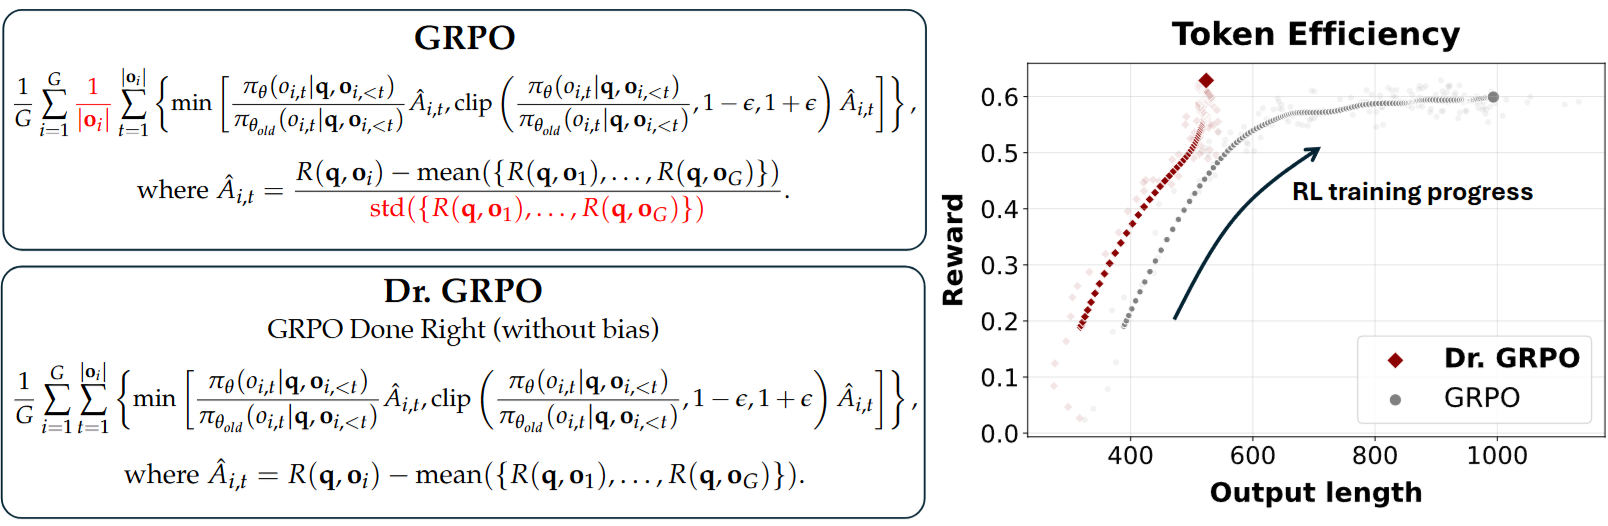

GRPO leverages this **relative preference** more effectively by comparing samples **within a group** of responses to the same prompt. Instead of updating the policy using individual sample rewards, GRPO:

1. Groups responses by the same prompt.
2. Computes **relative advantages** within each group:
   $$
   A_i = \text{reward}_i - \text{mean(rewards in group)}
   $$
3. Uses these relative advantages to update the model using a PPO-style objective:
   $$
   \mathcal{L}*{\text{GRPO}} = \mathbb{E}*i \Big[\min(r_i A_i, \text{clip}(r_i, 1 - \epsilon, 1 + \epsilon) A_i)\Big]
   $$
   where ( $r_i = \frac{\pi*\theta(a_i | s_i)}{\pi*{\text{ref}}(a_i | s_i)}$ ) is the **likelihood ratio** between the policy and reference models.

This ensures the model learns to *prefer relatively better responses* without depending on absolute reward scaling.


Key Benefits:

* **Stable training:** By normalizing rewards within groups, it mitigates outlier effects.
* **More sample-efficient:** Every group yields multiple gradient signals.
* **Alignment-friendly:** Works well with human or model preference data (as in RLHF or DPO setups).


GRPO needs log-probabilities for each sampled completion under both the policy and the frozen reference model. The helpers below combine prompts with completions, build attention masks that isolate the generated tokens, and return per-sequence log-probs.


In [12]:
def build_batch(prompts: Sequence[str], completions: Sequence[str], max_length: int = 2048) -> Dict[str, torch.Tensor]:
    input_ids: List[List[int]] = []
    attention_masks: List[List[int]] = []
    completion_masks: List[List[int]] = []
    for prompt, completion in zip(prompts, completions):
        prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
        completion_ids = tokenizer.encode(completion, add_special_tokens=False) + [tokenizer.eos_token_id]
        combined = prompt_ids + completion_ids
        combined = combined[:max_length]
        completion_mask = [0] * len(prompt_ids) + [1] * len(completion_ids)
        completion_mask = completion_mask[:max_length]
        attention = [1] * len(combined)
        pad = max_length - len(combined)
        if pad > 0:
            combined += [tokenizer.pad_token_id] * pad
            attention += [0] * pad
            completion_mask += [0] * pad
        input_ids.append(combined)
        attention_masks.append(attention)
        completion_masks.append(completion_mask)
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long, device=DEVICE),
        'attention_mask': torch.tensor(attention_masks, dtype=torch.long, device=DEVICE),
        'completion_mask': torch.tensor(completion_masks, dtype=torch.float, device=DEVICE),
    }

def sequence_logprobs(model: AutoModelForCausalLM, prompts: Sequence[str], completions: Sequence[str], max_length: int = 8192, detach: bool = True):
    batch = build_batch(prompts, completions, max_length=max_length)
    context = torch.no_grad() if detach else nullcontext()
    with context:
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits[:, :-1, :]
        labels = batch['input_ids'][:, 1:]
        log_probs = F.log_softmax(logits, dim=-1)
        token_logprobs = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
    mask = batch['completion_mask'][:, 1:]
    seq_logprobs = (token_logprobs * mask).sum(dim=-1)
    token_counts = mask.sum(dim=-1).clamp(min=1.0)
    if detach:
        return seq_logprobs.detach(), token_counts.detach()
    return seq_logprobs, token_counts

### 2.6 Sampling groups of completions

GRPO gathers multiple completions per prompt and uses their relative rewards as baselines. The function below returns a list of completions for each prompt and keeps track of all random seeds for reproducibility.


In [14]:
def sample_completions(model: AutoModelForCausalLM, prompts: Sequence[str], *, num_generations: int, max_new_tokens: int, temperature: float = 0.7, top_p: float = 0.9) -> List[List[str]]:
    completions: List[List[str]] = []
    for prompt in prompts:
        messages = [
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            temperature=temperature,
            top_p=top_p
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)
        outputs = model.generate(**model_inputs, do_sample=True, max_new_tokens=max_new_tokens, num_return_sequences=num_generations)
        prompt_len = model_inputs['input_ids'].size(1)
        generated = outputs[:, prompt_len:]
        texts = tokenizer.batch_decode(generated, skip_special_tokens=False)
        completions.append([text.strip() for text in texts])
    return completions

### 2.7 GRPO update step

The update uses per-group baselines — the mean reward of all completions for a prompt — to reduce variance. We normalise advantages inside each group, apply a KL penalty with respect to the frozen reference model, and clip gradients.


In [15]:
from tqdm import tqdm

@dataclass
class GRPOConfig:
    batch_size: int = 4
    num_generations: int = 4
    max_new_tokens: int = 8192
    max_length: int = 192
    temperature: float = 0.7
    top_p: float = 0.9
    learning_rate: float = 5e-5
    kl_coef: float = 0.05
    gradient_clip: float = 1.0
    num_steps: int = 30

config = GRPOConfig()
optimizer = torch.optim.AdamW([p for p in policy_model.parameters() if p.requires_grad], lr=config.learning_rate)

def grpo_update(prompts: Sequence[str]) -> Dict[str, float]:
    policy_model.train()
    completions = sample_completions(
        policy_model,
        prompts,
        num_generations=config.num_generations,
        max_new_tokens=config.max_new_tokens
    )
    flat_prompts: List[str] = []
    flat_completions: List[str] = []
    advantages: List[float] = []
    raw_rewards: List[float] = []
    for prompt, candidate_list in tqdm(zip(prompts, completions), desc="GRPO update", total=len(prompts), position=1, leave=False):
        group_rewards: List[float] = []
        for completion in candidate_list:
            reward, _ = sorting_reward(prompt, completion)
            group_rewards.append(reward)
            flat_prompts.append(prompt)
            flat_completions.append(completion)
        mean_reward = sum(group_rewards) / len(group_rewards)
        std_reward = statistics.pstdev(group_rewards)
        # denom = std_reward if std_reward > 1e-6 else 1.0
        denom = 1 # we use Dr. GRPO instead of GRPO
        for reward in group_rewards:
            advantages.append((reward - mean_reward) / denom)
            raw_rewards.append(reward)
    if not flat_prompts:
        return {'loss': 0.0, 'avg_reward': 0.0}

    policy_logprobs, token_counts = sequence_logprobs(
        policy_model,
        flat_prompts,
        flat_completions,
        max_length=config.max_length,
        detach=False,
    )
    ref_logprobs, _ = sequence_logprobs(
        reference_model,
        flat_prompts,
        flat_completions,
        max_length=config.max_length,
        detach=True,
    )
    advantages_tensor = torch.tensor(advantages, dtype=torch.float, device=policy_logprobs.device)
    lengths = token_counts.to(policy_logprobs.device)
    norm_policy = policy_logprobs / lengths
    norm_ref = ref_logprobs.to(policy_logprobs.device) / lengths
    loss_policy = -(advantages_tensor * norm_policy).mean()
    kl_term = (norm_policy - norm_ref).mean()
    loss = loss_policy + config.kl_coef * kl_term
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_model.parameters(), config.gradient_clip)
    optimizer.step()
    return {
        'loss': float(loss.detach().cpu()),
        'policy_term': float(loss_policy.detach().cpu()),
        'kl_term': float(kl_term.detach().cpu()),
        'avg_reward': float(sum(raw_rewards) / max(len(raw_rewards), 1)),
    }

### 2.8 Training loop with evaluation hooks

We iterate over random prompts, run a GRPO update, and periodically measure success on held-out prompts using greedy decoding.


In [17]:
def generate_completion(model: AutoModelForCausalLM, prompt: str, max_new_tokens: int = 8192) -> str:
    encoded = tokenizer(prompt, return_tensors='pt').to(DEVICE)
    output = model.generate(
        **encoded,
        do_sample=False,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    prompt_len = encoded['input_ids'].size(1)
    completion = tokenizer.decode(output[0][prompt_len:], skip_special_tokens=False)
    print(completion)
    return completion.strip()

def evaluate_success(model: AutoModelForCausalLM, dataset: Dataset, num_examples: int = 32) -> Dict[str, float]:
    subset = dataset.shuffle(seed=1234).select(range(min(num_examples, len(dataset))))
    successes = []
    rewards = []
    for example in tqdm(subset, desc="Evaluating success", position=1, leave=False):
        completion = generate_completion(model, example['prompt'])
        reward, components = sorting_reward(example['prompt'], completion)
        rewards.append(reward)
        successes.append(1.0 if components['exact'] == 1.0 else 0.0)
    return {
        'avg_reward': float(sum(rewards) / max(len(rewards), 1)),
        'exact_match_rate': float(sum(successes) / max(len(successes), 1)),
    }

rng = random.Random(0)
metrics_history: List[Dict[str, float]] = []
dataset_list = list(training_ds)
for step in tqdm(range(config.num_steps), desc="GRPO training", position=0):
    batch = rng.sample(dataset_list, k=min(config.batch_size, len(dataset_list)))
    prompts = [item['prompt'] for item in batch]
    metrics = grpo_update(prompts)
    if step % 5 == 0:
        eval_metrics = evaluate_success(policy_model, test_ds, num_examples=8)
        metrics.update({f'eval_{k}': v for k, v in eval_metrics.items()})
        print(f"Step {step}: {metrics}")
    metrics['step'] = step
    metrics_history.append(metrics)


GRPO training:   0%|          | 0/30 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


GRPO training:   0%|          | 0/30 [06:18<?, ?it/s]


KeyboardInterrupt: 

### 2.9 Inspecting the tuned model

After RL in verifiable domains, let's see what the average reward is for the test set.


In [ ]:
rlvr_eval_results = evaluate_model_on_dataset(policy_model, test_ds.select(range(10)))
print("RLVR model average reward:", sft_eval_results)

## Takeaways

* LoRA adapters collapse the fine-tuning footprint of a dense linear layer while maintaining accuracy when the required update is approximately low rank.
* Supervised warm-starting with structured `<think>...</think>` exemplars teaches the LoRA adapter to emit both reasoning tokens and the final sorted answer before RL.
* GRPO-style updates combined with PEFT adapters on Qwen 2.5 7B provide a practical recipe for reinforcement learning on consumer hardware.
